In [1]:
creds = ''

In [2]:
from pathlib import Path

creds_path = Path('~/.config/kaggle/kaggle.json').expanduser()

In [4]:
import os

if not creds_path.exists():
    os.makedirs(creds_path.parent, exist_ok = True)
    creds_path.write_text(creds)
    creds_path.chmod(0o600)

In [5]:
import kaggle


iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    local_path = Path(f'ignore/{path}')
    if not local_path.exists():
        kaggle.api.authenticate()
        import zipfile, kaggle
        kaggle.api.competition_download_cli('titanic', path='ignore')
        zipfile.ZipFile(f'{local_path}.zip').extractall(local_path)

In [6]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [8]:
path = local_path
path

Path('ignore/titanic')

## Prep the data

In [10]:
df = pd.read_csv(path/'train.csv')

In [34]:
def add_features(df):
    df['LogFare'] = np.log1p(df.Fare)
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family == 1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.',expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

# df[['Fare','LogFare']].head()
# df[['Deck','Cabin']].head(30)
# df[['Family', 'SibSp', 'Parch']].head()
# df.TicketFreq.head(30)
# df[['Title','Name']].head()

add_features(df)

In [35]:
splits = RandomSplitter(seed=42)(df)

In [36]:
dls = TabularPandas(df, splits=splits, 
                    procs=[Categorify, FillMissing, Normalize], 
                    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
                    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
                    y_names='Survived', y_block=CategoryBlock()).dataloaders(path=".")

/root/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


## Train the model

In [40]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

/root/miniconda3/lib/python3.12/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_

SuggestedLRs(slide=0.0831763744354248, valley=0.010964781977236271)

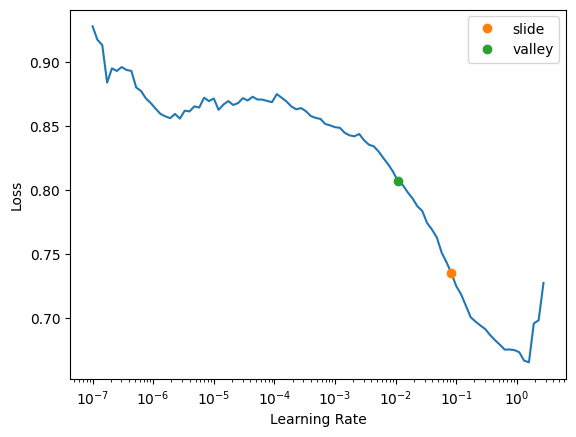

In [41]:
learn.lr_find(suggest_funcs=(slide, valley))

In [42]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.614984,0.564809,0.707865,00:00
1,0.539701,0.435084,0.808989,00:00
2,0.497752,0.415376,0.820225,00:00
3,0.474300,0.411007,0.814607,00:00
4,0.446353,0.431996,0.820225,00:00
5,0.442698,0.421474,0.820225,00:00
6,0.428273,0.428838,0.825843,00:00
7,0.420370,0.434060,0.814607,00:00
8,0.418401,0.443409,0.808989,00:00
9,0.412052,0.420195,0.820225,00:00


## Submit to Kaggle

In [49]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [50]:
# test_dl = learn.dls.test_dls(test_df)
tst_dl = learn.dls.test_dl(tst_df)


/root/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [51]:
preds,_ = learn.get_preds(dl=tst_dl)

In [52]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [53]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,0
899,0
900,1


## Ensembling

In [56]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(), learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [57]:
learns = [ensemble() for _ in range(5)]

In [61]:
ens_preds = torch.stack(learns).mean(0)

In [62]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

In [63]:
!head ens_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
